# Using data to decide where to open a new coffee shop

## Analysis based on Helsinki capital region open data

![Coffee shop](jazmin-quaynor-9Y8vxVQN4o4-unsplash_s.png)


## Introduction
Good Coffee Company Ltd has decided to expand to the Helsinki capital region. One question remains: Which neighborhood would be a good location for the new coffee shop?

To provide some basis for this decision, let's analyze some data about the Helsinki capital region. We would like to see some data about the economic situation in the neighborhoods, and also would like to include some analysis of the existing offering of cafés in the area.

Helsinki capital region is an area which contains the cities of Vantaa, Espoo and Kauniainen, in addition to the capital of Finland: Helsinki. There are approximately 1.19 million inhabitants in the Helsinki capital region.

The aim of this study is to help the stakeholders of this imaginary coffee company to decide where to open a new cafe in the helsinki metropolitan region. The company does not previously have a cafe in Helsinki.

This study/notebook could also be used as a starting point for any other futher analysis of Helsinki region data.

### Map of Helsinki metropolitan area

![Map Helsinki metropolitan area](helsinki_capital_region.PNG)

## Data

Data from several sources will be combined for this analysis. The main data sources will be the statistics institute of Finland (stat.fi), and the helsinki region infoshare site (hri.fi). Foursquare places API (https://developer.foursquare.com/docs/places-api/) will also be used to get data about the different venues around the region.

### Map data
The map data about the postal areas can be fetched from here: https://hri.fi/data/fi/dataset//paakaupunkiseudun-postinumeroalueet

The map data was in KML format and was converted to GeoJSON format using python package "kml2geojson".

### Economics data

The main economics data about the region can be fetched from here.

https://pxnet2.stat.fi/PXWeb/pxweb/fi/Postinumeroalueittainen_avoin_tieto/Postinumeroalueittainen_avoin_tieto__2021/paavo_pxt_12f7.px/

One challenge is that the coordinate data about the postal code areas is in EUREF-FIN -format. This data has to be converted to the international WGS84 coordinate system so that it can be fed to the Foursquare API. For this conversion I will be using python package "pyproj".

We will use the economics data to clearly define what kind of population lives in the different areas, and what kind of buying power they have. We will also try to look into the amount of offices and businesses versus homes, hypothesis being that if there are offices nearby maybe the workers would use the cafe during the office hours.

### The venue data

For the venue data we will be using Foursquare API (https://developer.foursquare.com/docs/places-api/). The venue data will help to establish knowledge of the existing competition and other venues as well. To match the venue data to the postal code areas we would need the coordinates for the approximate center of each postal code.

## Analysis


In [137]:
import numpy as np
import pandas as pd
import folium
import json
import seaborn as sns
from matplotlib import pyplot as plt


In [187]:
# Let's get the general postal area data into a dataframe
postalareas_df = pd.read_csv("009_12f7_2021.csv",skiprows=2, encoding='ansi')

# split 'Postinumeroalue' into postal code and area name
postalareas_df[['Postalcode','Areaname']] = postalareas_df.Postinumeroalue.str.split(" ", n=1,expand=True)

# drop the old 'Postinumeroalue' column
postalareas_df = postalareas_df.drop('Postinumeroalue',axis=1)

# strip the city name from the areanames
postalareas_df['Areaname'] = postalareas_df['Areaname'].map(lambda x: x.replace(' (Helsinki)','').replace(' (Vantaa)','').replace(' (Espoo)','').replace(' (Kauniainen)',''))

postalareas_df = postalareas_df.replace('...', 0)
postalareas_df = postalareas_df.astype({'Opiskelijat, 2018 (PT)': int, 'Eläkeläiset, 2018 (PT)': int, 'Lapset 0-14 -vuotiaat, 2018 (PT)': int })
# show results
postalareas_df.head()

,X-koordinaatti metreinä,Y-koordinaatti metreinä,Postinumeroalueen pinta-ala,"Asukkaat yhteensä, 2019 (HE)","Miehet, 2019 (HE)","Naiset, 2019 (HE)","Asukkaiden keski-ikä, 2019 (HE)","0-2-vuotiaat, 2019 (HE)","3-6-vuotiaat, 2019 (HE)","7-12-vuotiaat, 2019 (HE)",...,"X Toimiala tuntematon, 2018 (TP)","Asukkaat yhteensä, 2018 (PT)","Työlliset, 2018 (PT)","Työttömät, 2018 (PT)","Lapset 0-14 -vuotiaat, 2018 (PT)","Opiskelijat, 2018 (PT)","Eläkeläiset, 2018 (PT)","Muut, 2018 (PT)",Postalcode,Areaname
0,384979,6672361,2353278,18334,8661,9673,41,402,507,723,...,3,18427,10576,607,1846,1227,3420,751,00100,Helsinki Keskusta - Etu-Töölö
1,385531,6671434,414010,7140,3379,3761,41,151,232,333,...,0,7161,4081,241,829,419,1243,348,00120,Punavuori
2,386244,6671474,428960,1582,763,819,41,41,45,72,...,0,1523,876,37,172,86,266,86,00130,Kaartinkaupunki
3,386394,6670766,931841,7958,3625,4333,42,192,259,423,...,0,7921,4251,261,986,459,1530,434,00140,Kaivopuisto - Ullanlinna
4,385320,6670373,1367328,9420,4323,5097,40,221,268,406,...,0,9385,5514,364,957,527,1544,479,00150,Eira - Hernesaari


In [188]:
# How many many postal code areas are there?
print("Count of postal code areas is {}".format(postalareas_df.shape[0]))

Count of postal code areas is 168


### Let's see the distribution of the postal code area sizes by the number of inhabitants

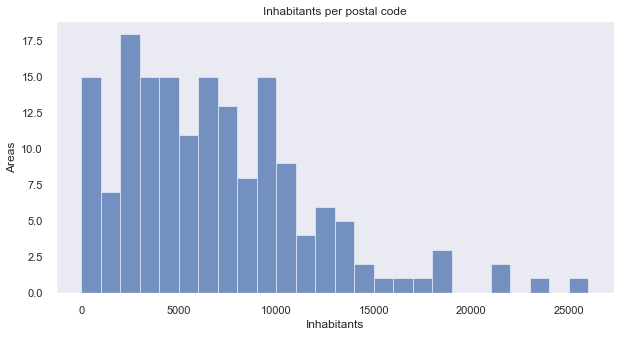

In [189]:

sns.set_theme(style="dark")
fig, ax = plt.subplots(figsize=(10,5))
pop_chart = sns.histplot(
    ax = ax,
    x="Asukkaat yhteensä, 2019 (HE)",
    data=postalareas_df,
    bins=20,
    binwidth=1000,
    linewidth=.5
)
pop_chart.set_title('Inhabitants per postal code')
plt.xlabel("Inhabitants")
plt.ylabel("Areas")
plt.show()

So most postal code areas are between 0 and 10000 inhabitants, with some areas going up to 25000 inhabitants.

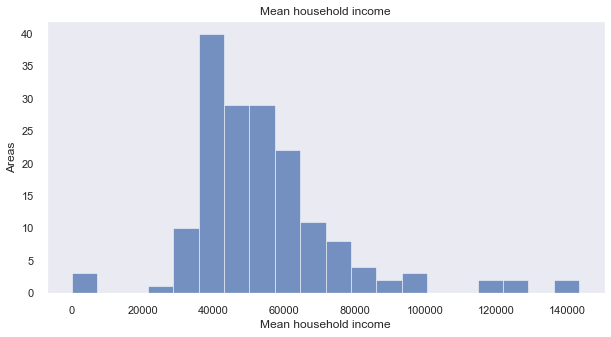

In [190]:
# Let's see the median income distribution

fig, ax = plt.subplots(figsize=(10,5))
pop_chart = sns.histplot(
    x="Talouksien keskitulot, 2019 (TR)",
    data=postalareas_df,
    bins=20,
    linewidth=.5
)
pop_chart.set_title('Mean household income')
plt.xlabel("Mean household income")
plt.ylabel("Areas")
plt.show()


In [191]:
# Before mapping we need the latitude and longitude for postal code areas, so let's transform those now using pyproj module
from pyproj import CRS
from pyproj import Transformer

# This is the target coordinate system that Foursquare understands
crs_4326 = CRS("WGS84")

# The source data is in this coordinate system
etrs_fin = CRS("ETRS89 / TM35FIN(E,N)")

# Create a transformer between source and target coordinate systems
transformer = Transformer.from_crs(etrs_fin, crs_4326)

latitudes = []
longitudes = []

# Transform each row in the dataframe separately
for i, row in postalareas_df.iterrows():
    xx = row['X-koordinaatti metreinä']
    yy = row['Y-koordinaatti metreinä']

    res = transformer.transform(xx, yy)

    latitudes.append(res[0])
    longitudes.append(res[1])

# Add the transformed data back to the dataframe
postalareas_df['latitude'] = latitudes
postalareas_df['longitude'] = longitudes
postalareas_df[['Postalcode','latitude','longitude']].head()

postalareas_df[postalareas_df['Postalcode']=='00510']
# So now we have nice data of the location of each postal code, ready to be used as a source in mapping

,X-koordinaatti metreinä,Y-koordinaatti metreinä,Postinumeroalueen pinta-ala,"Asukkaat yhteensä, 2019 (HE)","Miehet, 2019 (HE)","Naiset, 2019 (HE)","Asukkaiden keski-ikä, 2019 (HE)","0-2-vuotiaat, 2019 (HE)","3-6-vuotiaat, 2019 (HE)","7-12-vuotiaat, 2019 (HE)",...,"Työlliset, 2018 (PT)","Työttömät, 2018 (PT)","Lapset 0-14 -vuotiaat, 2018 (PT)","Opiskelijat, 2018 (PT)","Eläkeläiset, 2018 (PT)","Muut, 2018 (PT)",Postalcode,Areaname,latitude,longitude
35,386306,6674580,1062161,9814,4707,5107,39,255,220,204,...,6269,555,679,511,1423,346,00510,Etu-Vallila - Alppila,60.192183,24.949534


### Let's see the postal code areas on map

In [192]:
helsinki_latitude = 60.192059
helsinki_longitude = 24.945831

areas_geo = r'PKS_Postinumeroalueet_manner_2019.json'

map_helsinki = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11.5,tiles="cartodbpositron")

#df_temp = asda_df.replace('Postalcode')

map_helsinki.choropleth(
    geo_data=areas_geo,
    key_on='feature.properties.name',
    fill_color='YlGn', 
    fill_opacity=0.0, 
    line_opacity=0.3,
    legend_name='Postal code areas',
    smooth_factor=0,
    reset=True
    )

for i, row in postalareas_df.iterrows():
    folium.Marker([row['latitude'],row['longitude']], popup="" + row['Postalcode'] + " " +row['Areaname'] + " " + str(row['latitude']) + "," + str(row['longitude']) ).add_to(map_helsinki)


folium.LayerControl().add_to(map_helsinki)

#folium.TileLayer('cartodbpositron').add_to(map_helsinki)

map_helsinki

Let's classify the areas by clustering


In [193]:

# "Asukkaiden mediaanitulot, 2019 (HR)"
# Postinumeroalueen pinta-ala
# Talouksien keskitulot, 2019 (TR)
# "Postinumeroalueen pinta-ala"
# "Asukkaat yhteensä, 2019 (HE)"
# "Talouksien ostovoimakertymä, 2019 (TR)"
# "Työpaikat yhteensä, 2018 (TP)"

postalareas_cluster_df = postalareas_df[["Postalcode","Talouksien keskitulot, 2019 (TR)","Työpaikat yhteensä, 2018 (TP)"]]
postalareas_cluster_df['PopulationPerSquareKm'] = postalareas_df["Asukkaat yhteensä, 2019 (HE)"] / ( postalareas_df["Postinumeroalueen pinta-ala"] / 1000000 )

# What proportion are students out of the whole population?
postalareas_cluster_df['Students'] = postalareas_df["Opiskelijat, 2018 (PT)"] / postalareas_df["Asukkaat yhteensä, 2018 (PT)"]
postalareas_cluster_df['Students'] = postalareas_cluster_df['Students'].fillna(0)

# What proportion are pensioners out of the whole population?
postalareas_cluster_df['Pensioners'] = postalareas_df["Eläkeläiset, 2018 (PT)"] / postalareas_df["Asukkaat yhteensä, 2018 (PT)"]
postalareas_cluster_df['Pensioners'] = postalareas_cluster_df['Pensioners'].fillna(0)

# What proportion are children out of the whole population?
postalareas_cluster_df['Children'] = postalareas_df["Lapset 0-14 -vuotiaat, 2018 (PT)"] / postalareas_df["Asukkaat yhteensä, 2018 (PT)"]
postalareas_cluster_df['Children'] = postalareas_cluster_df['Children'].fillna(0)

#  Which proportion of people are 
postalareas_cluster_df['UniversityDegrees'] =  postalareas_df["Ylemmän korkeakoulututkinnon suorittaneet, 2019 (KO)"] / postalareas_df["Asukkaat yhteensä, 2019 (HE)"]

# fill NaN's with 0's
postalareas_cluster_df['UniversityDegrees'] = postalareas_cluster_df['UniversityDegrees'].fillna(0)

postalareas_cluster_df = postalareas_cluster_df.drop(labels='Postalcode',axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
postalareas_standardized_df = pd.DataFrame(scaler.fit_transform(postalareas_cluster_df), columns = postalareas_cluster_df.columns)
#postalareas_standardized_df


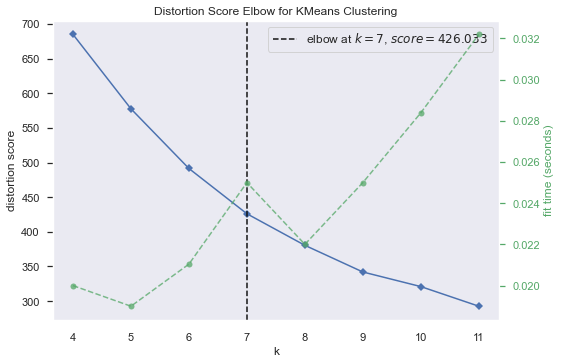

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [194]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(postalareas_standardized_df)  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# So the optimal seems to be 7

In [195]:

kclusters = 6

# Train k-means clustering model
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(postalareas_standardized_df)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([4, 4, 3, 3, 3, 3, 4, 4, 2, 3, 3, 4, 5, 0, 3, 3, 0, 0, 3, 0])

In [196]:
postalareas_cluster_df.insert(0, 'EconomicAreaLabel', kmeans.labels_)
postalareas_cluster_grouped_df = postalareas_cluster_df.groupby(by='EconomicAreaLabel').mean()
postalareas_cluster_grouped_df

,"Talouksien keskitulot, 2019 (TR)","Työpaikat yhteensä, 2018 (TP)",PopulationPerSquareKm,Students,Pensioners,Children,UniversityDegrees
EconomicAreaLabel,,,,,,,
0,44012.592593,3125.407407,3214.307159,0.070048,0.208796,0.153258,0.140508
1,23036.000000,19460.000000,2056.591200,0.357962,0.022139,0.032542,0.170388
2,62568.404255,1680.127660,1228.652666,0.074404,0.135956,0.221704,0.158375
3,81284.280000,3447.640000,3578.909491,0.065203,0.218748,0.150185,0.303883
4,50293.666667,15090.444444,11841.345893,0.068471,0.154469,0.094668,0.255212
5,14857.800000,5459.200000,9.805237,0.020842,0.036050,0.031049,0.015923


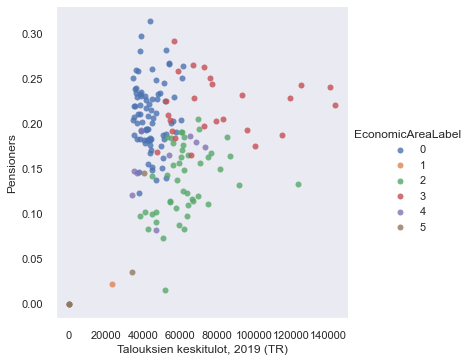

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt
facet = sns.lmplot(data=postalareas_cluster_df, x='Talouksien keskitulot, 2019 (TR)', y='Pensioners', hue='EconomicAreaLabel',
                   fit_reg=False, legend=True, legend_out=True)




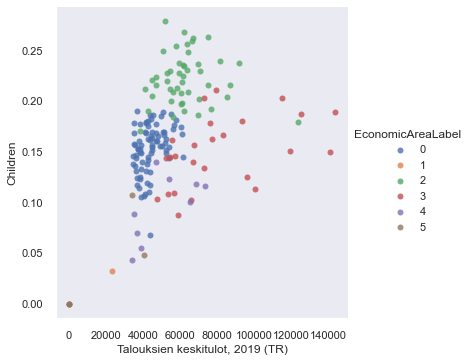

In [203]:
facet = sns.lmplot(data=postalareas_cluster_df, x='Talouksien keskitulot, 2019 (TR)', y='Children', hue='EconomicAreaLabel',
                   fit_reg=False, legend=True, legend_out=True)

In [216]:
# Based on this data we can give names to the area clusters
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 0, 'EconomicArea'] = 'LowIncome, Pensioners'
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 1, 'EconomicArea'] = 'LowIncome, Workers'
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 2, 'EconomicArea'] = 'MiddleIncome, Children'
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 3, 'EconomicArea'] = 'HighIncome, University Educated'
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 4, 'EconomicArea'] = 'MiddleIncome, HighPopDensity'
postalareas_cluster_df.loc[postalareas_cluster_df['EconomicAreaLabel'] == 5, 'EconomicArea'] = 'LowIncome, LowPopDensity'

postalareas_cluster_df.head(10)

,EconomicAreaLabel,"Talouksien keskitulot, 2019 (TR)","Työpaikat yhteensä, 2018 (TP)",PopulationPerSquareKm,Students,Pensioners,Children,UniversityDegrees,EconomicArea
0,4,65379,51915,7790.834742,0.066587,0.185597,0.100179,0.329224,"MiddleIncome, HighPopDensity"
1,4,73655,7553,17245.960243,0.058511,0.173579,0.115766,0.315126,"MiddleIncome, HighPopDensity"
2,3,100200,12142,3687.989556,0.056467,0.174655,0.112935,0.335019,"HighIncome, University Educated"
3,3,96156,2673,8540.083555,0.057947,0.193157,0.124479,0.320181,"HighIncome, University Educated"
4,3,66032,5428,6889.349154,0.056153,0.164518,0.101971,0.303079,"HighIncome, University Educated"
5,3,72867,3482,8929.363413,0.060302,0.262399,0.134149,0.292219,"HighIncome, University Educated"
6,4,68310,9644,10498.455862,0.068712,0.179053,0.118212,0.337962,"MiddleIncome, HighPopDensity"
7,4,53916,22164,8124.276419,0.061769,0.164479,0.122825,0.240885,"MiddleIncome, HighPopDensity"
8,2,53083,445,977.76244,0.066478,0.142857,0.227723,0.200535,"MiddleIncome, Children"
9,3,57131,2266,6071.540646,0.055447,0.18341,0.146109,0.306778,"HighIncome, University Educated"


In [135]:
# Let's include foursquare API configuration

import config as cfg

CLIENT_ID = cfg.foursquare['CLIENT_ID']
CLIENT_SECRET = cfg.foursquare['CLIENT_SECRET']
VERSION = cfg.foursquare['VERSION']
LIMIT = 100

CHINESE_RESTAURANT = "4bf58dd8d48988d145941735"
FOOD_CATEGORY = "4d4b7105d754a06374d81259"

CATEGORIES = FOOD_CATEGORY

In [9]:
import requests
import json

def getNearbyVenues(postalcodes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for postalcode, lat, lng in zip(postalcodes, latitudes, longitudes):
        postalcode = str(postalcode)
        lat = str(lat)
        lng = str(lng)
        #print(postalcode + " " + lat + "," + lng)

        '''
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            CATEGORIES,
            LIMIT)
            
        # make the GET request
        json_res = requests.get(url).json()
        json_res
        
        f = open("data/venues_" + postalcode + ".txt", "w")
        json.dump(json_res,f)
        '''
        
        # The same here, during development to make things more reliable the resulting JSON was saved into a file for each neighborhood
        #
        # To fetch the data from Foursquare just uncomment the above code block and comment out the following 3 lines
        #
        f = open("data/venues_" + postalcode + ".txt", "r")
        json_res = json.load(f)
        f.close()

        #print( "json_res: " + str(json_res))

        results = json_res["response"]['groups'][0]['items']
        #print("results: " + str(results))
        

        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postalcode', 
                'Postalcode Latitude', 
                'Postalcode Longitude', 
                'Venue', 
                'Venue Latitude', 
                'Venue Longitude', 
                'Venue Category']
    
    return(nearby_venues)

In [10]:

# Let's grab the data we need to get the venue data
temp_df = postalareas_df[['Postalcode','latitude','longitude']]

#temp_df2 = temp_df[temp_df['Postalcode'] > '00510']
#print("temp_df2.head(55)" + str(temp_df2.head(55)))

postal_code_list = temp_df['Postalcode'].to_list()
latitude_list = temp_df['latitude'].to_list()
longitude_list = temp_df['longitude'].to_list()

#postal_code_list = ['00510']
#latitude_list = ['60.192183']
#longitude_list = ['24.949534']

#print( "postal_code_list: " + str(postal_code_list))
#print( "latitude_list: " + str(latitude_list))
#print( "longitude_list: " + str(longitude_list))

nearby_venues_df = getNearbyVenues(postal_code_list,latitude_list,longitude_list)

nearby_venues_df.head(5)

,Postalcode,Postalcode Latitude,Postalcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,00100,60.17189939106672,24.926875389936413,Ateljé Finne,60.171198,24.928515,Scandinavian Restaurant
1,00100,60.17189939106672,24.926875389936413,Young Hearts,60.171353,24.926107,Restaurant
2,00100,60.17189939106672,24.926875389936413,Twisted Street Kitchen,60.170641,24.928203,Asian Restaurant
3,00100,60.17189939106672,24.926875389936413,Fafa's,60.169876,24.927835,Falafel Restaurant
4,00100,60.17189939106672,24.926875389936413,Levain,60.173094,24.923056,Bakery


In [11]:
# one hot encoding
venues_onehot = pd.get_dummies(nearby_venues_df[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe
venues_onehot['Postalcode'] = nearby_venues_df['Postalcode'] 

# move postal code column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot

,Postalcode,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,...,Taco Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,00100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00100,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,02770,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1280,02780,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1281,02780,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1282,02820,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
venues_onehot_grouped = venues_onehot.groupby('Postalcode').mean().reset_index()
venues_onehot_grouped

,Postalcode,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,...,Taco Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,00100,0.000000,0.0,0.029412,0.0,0.00,0.058824,0.0,0.000000,0.0,...,0.029412,0.0,0.000000,0.00,0.0,0.00,0.000000,0.0,0.00,0.0
1,00120,0.020000,0.0,0.010000,0.0,0.01,0.050000,0.0,0.000000,0.0,...,0.000000,0.0,0.020000,0.01,0.0,0.01,0.030000,0.0,0.04,0.0
2,00130,0.052632,0.0,0.026316,0.0,0.00,0.000000,0.0,0.026316,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.00,0.078947,0.0,0.00,0.0
3,00140,0.000000,0.0,0.000000,0.0,0.00,0.055556,0.0,0.055556,0.0,...,0.000000,0.0,0.055556,0.00,0.0,0.00,0.000000,0.0,0.00,0.0
4,00150,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.100000,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.10,0.000000,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,02760,0.000000,0.0,0.000000,0.0,0.00,1.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000000,0.0,0.00,0.0
132,02770,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000000,0.0,0.00,0.0
133,02780,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000000,0.0,0.00,0.0
134,02820,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000000,0.0,0.00,0.0


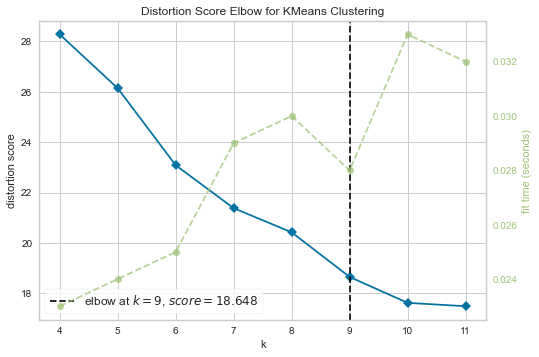

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Let's drop the Neighborhood column before feeding the dataframe into KMeans
venues_grouped_clustering = venues_onehot_grouped.drop('Postalcode', 1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(venues_grouped_clustering)  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# So based on this the optimal k would be 9

In [15]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 9

# Let's drop the Neighborhood column before feeding the dataframe into KMeans
venues_grouped_clustering = venues_onehot_grouped.drop('Postalcode', 1)

# Train k-means clustering model
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0])

In [16]:
# Let's create a new merged dataframe which will include cluster labels and lat&long information as well.

df_venue_clusters = postalareas_df[['Postalcode','Areaname','latitude','longitude']]
#df_venue_clusters

# Let's create cluster labels df
venues_clusters = venues_onehot_grouped[['Postalcode']]
venues_clusters.insert(0, 'VenueLabels', kmeans.labels_)

# Let's merge dataframes to add latitude/longitude for each neighborhood
df_merged = df_venue_clusters.join(venues_clusters.set_index('Postalcode'), on='Postalcode')
df_merged['VenueLabels'] = df_merged['VenueLabels'].fillna(-1)
df_merged['VenueLabels'] = df_merged['VenueLabels'].astype(int)
df_merged
#df_venue_clusters2 = df_venue_clusters.join(venues_onehot_grouped.set_index('Postalcode'), on='Postalcode')
#df_venue_clusters2
#df_merged.head(10)
#postalareas_df.head()

# So now finally we have venue clusters for all postal codes, with some postal codes being without cluster


,Postalcode,Areaname,latitude,longitude,Cluster Labels
0,00100,Helsinki Keskusta - Etu-Töölö,60.171899,24.926875,1
1,00120,Punavuori,60.163736,24.937339,1
2,00130,Kaartinkaupunki,60.164295,24.950154,1
3,00140,Kaivopuisto - Ullanlinna,60.157983,24.953251,1
4,00150,Eira - Hernesaari,60.154157,24.934137,1
...,...,...,...,...,...
163,02860,Siikajärvi,60.284217,24.512485,-1
164,02920,Niipperi,60.273161,24.739158,6
165,02940,Lippajärvi-Järvenperä,60.260066,24.697941,-1
166,02970,Kalajärvi,60.325323,24.716658,-1


In [17]:
import matplotlib.cm as cm
import matplotlib.colors as colors

cluster_map = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, poi, cluster in zip(df_merged['latitude'], df_merged['longitude'], df_merged['Postalcode'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=11,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
    
cluster_map